### Task
Try to learn the ff: formula

$\text{Given that:}$
$r = \sqrt{x^2 + y^2} \quad \text{where: } r, x, y \in [0, 1]$ 

/Users/jums/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/jums/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/jums/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


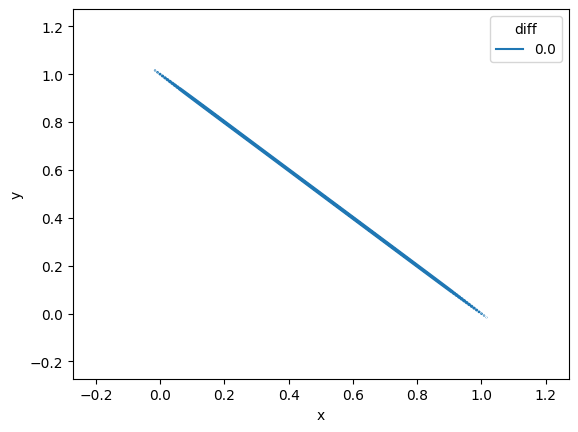

In [16]:
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
from jax import grad, jit, vmap, jacobian
import math
import seaborn as sns
import pandas as pd
import jax

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
x0_input = jax.random.uniform(key, shape=(1000,1), dtype=jnp.float32)
x1_input = 1.0 - x0_input
X_train = jnp.column_stack([x0_input, x1_input])
y_train = jnp.sum(X_train ** 2, axis=1).reshape(-1,1)
y_diff = y_train - y_train
data = jnp.column_stack([X_train, y_diff])
data = pd.DataFrame(data, columns=['x', 'y', 'diff'])
sns.kdeplot(data, x='x', y='y', cmap='reds', hue='diff')
plt.show()



In [68]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
import math
from jax.scipy.special import logsumexp
from jax.nn import sigmoid


# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(input_sizes, output_sizes):
  key =  random.PRNGKey(0)
  assert len(input_sizes) == len(output_sizes), 'input_sizes != output_sizes'
  keys = random.split(key, len(input_sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(input_sizes, output_sizes, keys)]

def display_params(params, params_name):
   print(f'{params_name} total num_layers = ', len(params))
   for level, param in enumerate(params, start=1):
      weight_shape = param[0].shape
      bias_shape = param[1].shape
      print(f'({level}) {params_name}_weights.shape = {weight_shape}, {params_name}_bias.shape = {bias_shape}')



In [85]:
def relu(x):
    return jnp.where(x >= 0, x, 0)

def mse(y_pred,y_target):
    return jnp.mean((y_pred - y_target) ** 2)

def linear(W, x):
    return x @ W

def predict(params, X):
    activations = X 
    for w, b in params[:-1]:
        outputs = activations @ w + b
        activations = relu(outputs)
    
    final_w = params[-1][0]
    final_b = params[-1][1]

    logits = activations @ final_w + final_b
    return jax.nn.sigmoid(logits)

@jit
def loss_func(params, X_train, y_train):
  preds = predict(params, X_train)
  return mse(preds, y_train)

### TODO:
- Investigate if these weights are actually computing the right gradients. Such that it computes $\partial f(x; \omega_{ij}) / \partial \omega_{ij}$ where $\omega_{ij}$ is the weights.
- Create a focused notebook on this part.

[10/100] Loss: 0.1481654942035675
[20/100] Loss: 0.1465713083744049
[30/100] Loss: 0.14501723647117615
[40/100] Loss: 0.14350254833698273
[50/100] Loss: 0.1420263797044754
[60/100] Loss: 0.1405879259109497
[70/100] Loss: 0.13918638229370117
[80/100] Loss: 0.13782091438770294
[90/100] Loss: 0.13649073243141174
[100/100] Loss: 0.13519500195980072


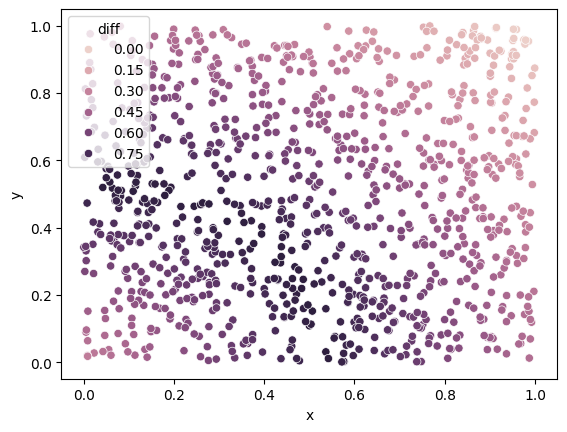

In [101]:
def generate_data(num_sample):
  key =  jax.random.PRNGKey(0)
  key, subkey = jax.random.split(key)
  x_input = jax.random.uniform(subkey, shape=(num_sample,2), dtype=jnp.float32)
  y_target = jnp.sqrt(jnp.sum(x_input ** 2, axis=1).reshape(-1,1))
  return x_input, y_target

def update_weights(params, X, y, step_size):
  grads = grad(loss_func)(params, X, y)

  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

def train_network(params, num_sample, num_epochs, step_size, step_display, current_round):
  for curr_epoch in range(1, num_epochs + 1):
    X_train, y_train = generate_data(num_sample)

    loss = loss_func(params, X_train, y_train)
    params = update_weights(params, X_train, y_train, step_size)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params, current_round + 1

def plot_contour(params, X, y_target):
  y_pred = predict(params, X)
  y_diff = jnp.max(jnp.abs(y_pred - y_target)) - jnp.abs(y_pred - y_target)
  # print(y_diff) 
  df = pd.DataFrame(jnp.column_stack([X, y_diff]), columns=['x', 'y', 'diff'])
  sns.scatterplot(df, x='x', y='y', hue='diff')
  sns.color_palette('colorblind')
  plt.show()
  # plt.show()
  # return df
 
sns.color_palette('muted')
num_hidden = 10
input_sizes = [2, num_hidden]
output_sizes = [num_hidden, 1]
num_sample = 2**10
num_epochs = 100
step_size = 0.01
step_display = 10
current_round = 1

key =  jax.random.PRNGKey(0)
params = init_network_params(input_sizes, output_sizes)
params, current_round = train_network(params, num_sample, num_epochs, step_size, step_display, current_round)
X_test, y_test = generate_data(num_sample)
plot_contour(params, X_test, y_test)
